# 네이버 영화리뷰 감성 분석

## 0) Import

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Komoran

## 1) 데이터 불러오기

In [11]:
train = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [5]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (150000, 3) 
test shape => (50000, 3)


In [6]:
train.columns

Index(['id', 'document', 'label'], dtype='object')

## 2) 훈련 데이터 라벨링 값 비율 확인

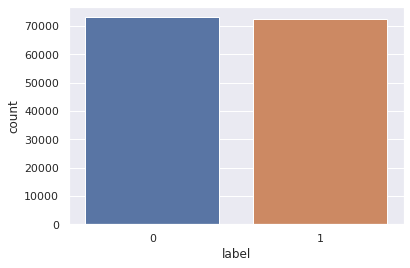

In [79]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

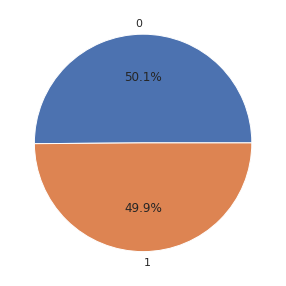

In [8]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3) 훈련, 테스트 데이터 결측치 값 확인

In [9]:
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [10]:
test.isnull().sum()

id          0
document    3
label       0
dtype: int64

## 4) 데이터 전처리
- 데이터 중복제거(drop_duplicates)  
- 결측치 제거(dropna)  
- 한국어 토크나이저를 활용한 토큰화(Komoran)  
- 불용어 제거(조사,구두점,접미사 종류)
- Bag of Words, word to index, index to word 구현  
- 문장 길이 분포와 적절 최대 문자 길이 지정  
- 최대 문자 길이에 따른 패딩 추가(pad_sequences)

In [11]:
from tqdm import tqdm, trange

In [12]:
tokenizer = Komoran()

def preprocess(train, test):
    train.drop_duplicates(subset=['document'], inplace=True)
    test.drop_duplicates(subset=['document'], inplace=True)
    train = train.dropna()
    test = test.dropna()
    print(f"train shape => {train.shape} \ntest shape => {test.shape}")
    
    train_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train['document']]
    test_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test['document']]
    
    exclusion_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC',
                      'SF', 'SP', 'SS', 'SE', 'SO', 'EF', 'EP', 'EC', 'ETN', 'ETM',
                      'XSN', 'XSV', 'XSA']
    
    f = lambda x: x in exclusion_tags
    
    X_train = []
    for i in trange(len(train_tokenized)):
        temp = []
        for j in range(len(train_tokenized[i])):
            if f(train_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_tokenized[i][j].split('/')[0])
        X_train.append(temp)
    
    X_test = []
    for i in trange(len(test_tokenized)):
        temp = []
        for j in range(len(test_tokenized[i])):
            if f(test_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_tokenized[i][j].split('/')[0])
        X_test.append(temp)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(30000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train['label'])), X_test, np.array(list(test['label'])), word_to_index

In [13]:
X_train, y_train, X_test, y_test, word_to_index = preprocess(train, test)

train shape => (146182, 3) 
test shape => (49157, 3)


100%|██████████| 49157/49157 [00:00<00:00, 65031.98it/s]


In [14]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [15]:
all_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in all_data]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 10.763011994532581
토큰 길이 최대: 140
토큰 길이 표준편차: 8.886926944778248
설정 최대 길이: 28
전체 문장의 0.9356554502685076%가 설정값인 28에 포함됩니다.


In [16]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=30)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=30)

In [17]:
print(f"X_train 1번째 값 길이 : {len(X_train[0])}\nX_test 1번째 값 길이 : {len(X_test[0])}")

X_train 1번째 값 길이 : 30
X_test 1번째 값 길이 : 30


# 모델 구성 및 validation set 구성

    모델 선정 이유
        - LSTM, Stacked LSTM, 1DConv
        - 일반적으로 자연어 분류 모델에서 자주 사용하는 모델들을 선정하였다 
    metrics 선정 이유
        - 데이터 label의 분포가 거의 1:1로 분포하여 accuracy를 사용하였다  
    loss 선정 이유
        - 이진 분류 문제이므로 binary cross entropy가 적절하다

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=777)

## 모델링 - LSTM

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [20]:
vocab_size = 10000
word_vector_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 3,009,897
Trainable params: 3,009,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[mc])

Epoch 1/10
3655/3655 [==============================] - 27s 6ms/step - loss: 0.3938 - accuracy: 0.8205 - val_loss: 0.3629 - val_accuracy: 0.8359

Epoch 00001: val_accuracy improved from -inf to 0.83589, saving model to lstm_best_model.h5
Epoch 2/10
3655/3655 [==============================] - 20s 5ms/step - loss: 0.3122 - accuracy: 0.8630 - val_loss: 0.3660 - val_accuracy: 0.8394

Epoch 00002: val_accuracy improved from 0.83589 to 0.83942, saving model to lstm_best_model.h5
Epoch 3/10
3655/3655 [==============================] - 20s 6ms/step - loss: 0.2672 - accuracy: 0.8855 - val_loss: 0.3782 - val_accuracy: 0.8386

Epoch 00003: val_accuracy did not improve from 0.83942
Epoch 4/10
3655/3655 [==============================] - 20s 6ms/step - loss: 0.2298 - accuracy: 0.9034 - val_loss: 0.4030 - val_accuracy: 0.8339

Epoch 00004: val_accuracy did not improve from 0.83942
Epoch 5/10
3655/3655 [==============================] - 20s 6ms/step - loss: 0.1978 - accuracy: 0.9186 - val_loss: 0.44

In [22]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 4s 2ms/step - loss: 0.6029 - accuracy: 0.8168
[0.6028519868850708, 0.8167504072189331]


In [72]:
def draw_graph(history):
    history_dict = history.history
    try:
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
    except:
        acc = history_dict['acc']
        val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


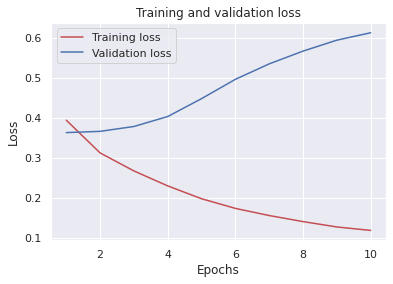

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 모델링 - Stacked LSTM

In [26]:
vocab_size = 10000
word_vector_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8, return_sequences = True))
model.add(tf.keras.layers.LSTM(units=16, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('stacked_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 8)           9888      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,011,505
Trainable params: 3,011,505
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 32s 8ms/step - loss: 0.3926 - accuracy: 0.8204 - val_loss: 0.3610 - val_accuracy: 0.8395

Epoch 00001: val_accuracy improved from -inf to 0.83948, saving model to stacked_lstm_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 26s 7ms/step - loss: 0.3096 - accuracy: 0.8654 - val_loss: 0.3526 - val_accuracy: 0.8428

Epoch 00002: val_accuracy improved from 0.83948 to 0.84277, saving model to stacked_lstm_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 27s 7ms/step - loss: 0.2617 - accuracy: 0.8894 - val_loss: 0.3702 - val_accuracy: 0.8378

Epoch 00003: val_accuracy did not improve from 0.84277
Epoch 4/20
3655/3655 [==============================] - 26s 7ms/step - loss: 0.2203 - accuracy: 0.9092 - val_loss: 0.4150 - val_accuracy: 0.8368

Epoch 00004: val_accuracy did not improve from 0.84277
Epoch 5/20
3655/3655 [==============================] - 26s 7ms/step - loss: 0.1867 - accuracy: 0.9245 

In [28]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.4398 - accuracy: 0.8303
[0.4398190975189209, 0.8303395509719849]


In [29]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


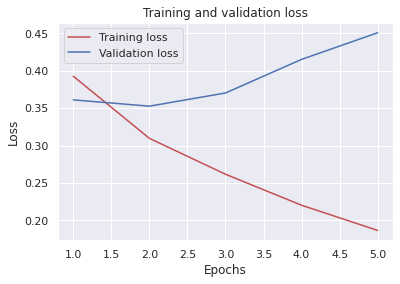

In [30]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- overfitting ...

### 모델링 - CNN

In [31]:
embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.5 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

vocab_size = 10000
word_vector_dim = 300

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         196864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [32]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 22s 5ms/step - loss: 0.4100 - acc: 0.8115 - val_loss: 0.3687 - val_acc: 0.8366

Epoch 00001: val_acc improved from -inf to 0.83658, saving model to cnn_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 18s 5ms/step - loss: 0.3306 - acc: 0.8577 - val_loss: 0.3577 - val_acc: 0.8435

Epoch 00002: val_acc improved from 0.83658 to 0.84345, saving model to cnn_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 18s 5ms/step - loss: 0.2897 - acc: 0.8781 - val_loss: 0.3652 - val_acc: 0.8400

Epoch 00003: val_acc did not improve from 0.84345
Epoch 4/20
3655/3655 [==============================] - 18s 5ms/step - loss: 0.2532 - acc: 0.8944 - val_loss: 0.3716 - val_acc: 0.8437

Epoch 00004: val_acc improved from 0.84345 to 0.84366, saving model to cnn_best_model.h5
Epoch 5/20
3655/3655 [==============================] - 18s 5ms/step - loss: 0.2239 - acc: 0.9076 - val_loss: 0.4081 - val_acc: 0.8412

Epoch 

In [33]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


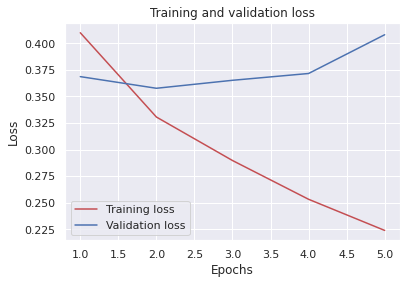

In [34]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
cnn_model = load_model('cnn_best_model.h5')
lstm_model = load_model('lstm_best_model.h5')
stacked_lstm_model = load_model('stacked_lstm_best_model.h5')

print("\ncnn 모델 테스트 정확도: %.4f" % (cnn_model.evaluate(X_test, y_test)[1]))
print("\nlstm 모델 테스트 정확도: %.4f" % (lstm_model.evaluate(X_test, y_test)[1]))
print("\nstacked lstm 모델 테스트 정확도: %.4f" % (stacked_lstm_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3671 - acc: 0.8452

cnn 모델 테스트 정확도: 0.8452
1537/1537 [==============================] - 4s 2ms/step - loss: 0.3652 - accuracy: 0.8396

lstm 모델 테스트 정확도: 0.8396
1537/1537 [==============================] - 6s 3ms/step - loss: 0.3527 - accuracy: 0.8433

stacked lstm 모델 테스트 정확도: 0.8433


## 학습된 Embedding 레이어 분석

In [36]:
from gensim.models import Word2Vec

In [37]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return list(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [38]:
tokenized_data = get_decoded_sentences(X_train, index_to_word)

In [39]:
tokens = []

for data in tokenized_data:
    data = [d for d in data if '<' not in d]
    tokens.append(data)

In [40]:
embedding_dim = 100

model = Word2Vec(  
    sentences = tokens,
    window = 5,  
    min_count = 5,  
    workers = 4,  
    sg = 0  
)

In [41]:
print(model.wv.vectors.shape)

(11367, 100)


In [42]:
word_vectors = model.wv  
vocabs = list(word_vectors.key_to_index)

In [43]:
for sim_word in model.wv.most_similar("영화"):  
    print(sim_word)

('애니메이션', 0.6549390554428101)
('영화로', 0.6457005143165588)
('애니', 0.6095291376113892)
('작품', 0.5860108733177185)
('수작', 0.5476568937301636)
('드라마', 0.5193130970001221)
('명작', 0.5025134682655334)
('공포물', 0.48621439933776855)
('재밌는 영화', 0.4850658178329468)
('액션 영화', 0.4796587824821472)


## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [44]:
import os

In [45]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'

In [46]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [47]:
word_vectors.wv.most_similar('영화')

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [48]:
vocab_size = 10000
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv.key_to_index:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

## 1D CNN 모델

In [49]:
from tensorflow.keras.initializers import Constant

In [50]:
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 256)         77056     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [51]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 17s 4ms/step - loss: 0.5934 - acc: 0.6829 - val_loss: 0.4531 - val_acc: 0.7918

Epoch 00001: val_acc improved from -inf to 0.79177, saving model to embedding_cnn_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 16s 4ms/step - loss: 0.4724 - acc: 0.7813 - val_loss: 0.4039 - val_acc: 0.8130

Epoch 00002: val_acc improved from 0.79177 to 0.81301, saving model to embedding_cnn_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 16s 4ms/step - loss: 0.4326 - acc: 0.8064 - val_loss: 0.3824 - val_acc: 0.8242

Epoch 00003: val_acc improved from 0.81301 to 0.82416, saving model to embedding_cnn_best_model.h5
Epoch 4/20
3655/3655 [==============================] - 16s 4ms/step - loss: 0.4086 - acc: 0.8198 - val_loss: 0.3766 - val_acc: 0.8288

Epoch 00004: val_acc improved from 0.82416 to 0.82881, saving model to embedding_cnn_best_model.h5
Epoch 5/20
3655/3655 [==============================] - 16s 4ms

In [52]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


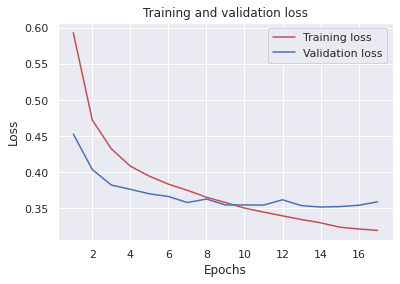

In [53]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [54]:
embedding_cnn_model = load_model('embedding_cnn_best_model.h5')

print("\nWord2vec 임베딩 후 cnn 모델 테스트 정확도: %.4f" % (embedding_cnn_model .evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3513 - acc: 0.8486

Word2vec 임베딩 후 cnn 모델 테스트 정확도: 0.8486


### lstm 모델 (Trainable True)

In [55]:
from keras.models import Sequential
from keras.layers import *

In [56]:
vocab_size = 10000
word_vector_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 1,003,497
Trainable params: 1,003,497
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/10
3655/3655 [==============================] - 20s 5ms/step - loss: 0.4497 - accuracy: 0.7839 - val_loss: 0.3963 - val_accuracy: 0.8212

Epoch 00001: val_accuracy improved from -inf to 0.82115, saving model to embedding_lstm_best_model.h5
Epoch 2/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.3599 - accuracy: 0.8407 - val_loss: 0.3818 - val_accuracy: 0.8289

Epoch 00002: val_accuracy improved from 0.82115 to 0.82888, saving model to embedding_lstm_best_model.h5
Epoch 3/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.3315 - accuracy: 0.8560 - val_loss: 0.3780 - val_accuracy: 0.8317

Epoch 00003: val_accuracy improved from 0.82888 to 0.83169, saving model to embedding_lstm_best_model.h5
Epoch 4/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.3119 - accuracy: 0.8654 - val_loss: 0.3808 - val_accuracy: 0.8322

Epoch 00004: val_accuracy improved from 0.83169 to 0.83223, saving model to embedding_lstm_best_model.h5

In [58]:
predict = model.evaluate(X_test, y_test, verbose=1)
print("\nWord2vec 임베딩 후 lstm 모델 테스트 정확도: %.4f" % (predict[1]))

1537/1537 [==============================] - 4s 2ms/step - loss: 0.3916 - accuracy: 0.8325

Word2vec 임베딩 후 lstm 모델 테스트 정확도: 0.8325


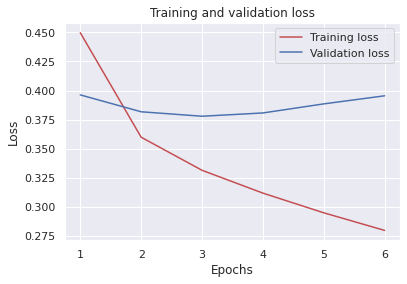

In [59]:
draw_graph(history)

## lstm (trainable=False)

In [60]:
vocab_size = 10000
word_vector_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=False))
model.add(tf.keras.layers.LSTM(units=10))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_lstm_tr_false.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 1,004,451
Trainable params: 4,451
Non-trainable params: 1,000,000
_________________________________________________________________


In [61]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.5000 - accuracy: 0.7540 - val_loss: 0.4708 - val_accuracy: 0.7745

Epoch 00001: val_accuracy improved from -inf to 0.77450, saving model to embedding_lstm_tr_false.h5
Epoch 2/10
3655/3655 [==============================] - 16s 4ms/step - loss: 0.4396 - accuracy: 0.7960 - val_loss: 0.4423 - val_accuracy: 0.7904

Epoch 00002: val_accuracy improved from 0.77450 to 0.79037, saving model to embedding_lstm_tr_false.h5
Epoch 3/10
3655/3655 [==============================] - 16s 4ms/step - loss: 0.4226 - accuracy: 0.8058 - val_loss: 0.4323 - val_accuracy: 0.7980

Epoch 00003: val_accuracy improved from 0.79037 to 0.79803, saving model to embedding_lstm_tr_false.h5
Epoch 4/10
3655/3655 [==============================] - 16s 4ms/step - loss: 0.4135 - accuracy: 0.8095 - val_loss: 0.4296 - val_accuracy: 0.7999

Epoch 00004: val_accuracy improved from 0.79803 to 0.79995, saving model to embedding_lstm_tr_false.h5
Epoch 5

In [62]:
predict = model.evaluate(X_test, y_test, verbose=1)
print("\nWord2vec 임베딩 후 lstm 모델 테스트 정확도: %.4f" % (predict[1]))

1537/1537 [==============================] - 4s 2ms/step - loss: 0.4147 - accuracy: 0.8096

Word2vec 임베딩 후 lstm 모델 테스트 정확도: 0.8096


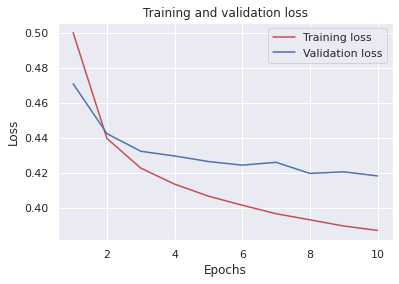

In [63]:
draw_graph(history)

### Stacked LSTM

In [64]:
vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(tf.keras.layers.LSTM(units=8, return_sequences = True))
model.add(tf.keras.layers.LSTM(units=16, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_stacked_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 8)           3488      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 1,005,105
Trainable params: 1,005,105
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 28s 7ms/step - loss: 0.4351 - accuracy: 0.7938 - val_loss: 0.3855 - val_accuracy: 0.8233

Epoch 00001: val_accuracy improved from -inf to 0.82334, saving model to embedding_stacked_lstm_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 25s 7ms/step - loss: 0.3506 - accuracy: 0.8438 - val_loss: 0.3684 - val_accuracy: 0.8324

Epoch 00002: val_accuracy improved from 0.82334 to 0.83240, saving model to embedding_stacked_lstm_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 25s 7ms/step - loss: 0.3235 - accuracy: 0.8582 - val_loss: 0.3689 - val_accuracy: 0.8340

Epoch 00003: val_accuracy improved from 0.83240 to 0.83398, saving model to embedding_stacked_lstm_best_model.h5
Epoch 4/20
3655/3655 [==============================] - 25s 7ms/step - loss: 0.3040 - accuracy: 0.8695 - val_loss: 0.3694 - val_accuracy: 0.8371

Epoch 00004: val_accuracy improved from 0.83398 to 0.83712, saving model to embe

In [66]:
predict = model.evaluate(X_test, y_test, verbose=1)
print("\nWord2vec 임베딩 후 Stacked LSTM 모델 테스트 정확도: %.4f" % (predict[1]))

1537/1537 [==============================] - 5s 3ms/step - loss: 0.3821 - accuracy: 0.8353

Word2vec 임베딩 후 Stacked LSTM 모델 테스트 정확도: 0.8353


# 전처리부터 다시
- 성능 개선을 위해 전처리부터 다시 진행하였다

In [12]:
from tqdm import tqdm, trange

In [15]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','을','으로','자','에','와','한','하다','하']
okt = Okt()

In [17]:
def preprocessing(test_data):
    test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
    
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
    test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
    test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
    test_data = test_data.dropna(how='any') # Null 값 제거
    print('전처리 후 테스트용 샘플의 개수 :',len(test_data))
    
    X_test = []
    for sentence in tqdm(test_data['document']):
        temp_X = okt.morphs(sentence, stem=True) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    return X_test, test_data

In [18]:
X_train, train = preprocessing(train)

/tmp/ipykernel_1496/1560195211.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_1496/1560195211.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


전처리 후 테스트용 샘플의 개수 : 145393


100%|██████████| 145393/145393 [08:00<00:00, 302.30it/s]


In [19]:
X_test, test = preprocessing(test)

/tmp/ipykernel_1496/1560195211.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_1496/1560195211.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


전처리 후 테스트용 샘플의 개수 : 48852


100%|██████████| 48852/48852 [02:58<00:00, 273.37it/s]


In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'영화': 1, '보다': 2, '없다': 3, '이다': 4, '있다': 5, '좋다': 6, '너무': 7, '다': 8, '정말': 9, '되다': 10, '재밌다': 11, '적': 12, '만': 13, '같다': 14, '진짜': 15, '로': 16, '아니다': 17, '않다': 18, '점': 19, '에서': 20, '만들다': 21, '나오다': 22, '연기': 23, '것': 24, '평점': 25, '내': 26, '최고': 27, '그': 28, '나': 29, '안': 30, '인': 31, '스토리': 32, '생각': 33, '못': 34, '왜': 35, '드라마': 36, '게': 37, '감동': 38, '사람': 39, '보고': 40, '이렇다': 41, '말': 42, '고': 43, '아깝다': 44, '더': 45, '배우': 46, '때': 47, 'ㅋㅋ': 48, '아': 49, '감독': 50, '거': 51, '그냥': 52, '재미있다': 53, '요': 54, '재미': 55, '시간': 56, '내용': 57, '뭐': 58, '까지': 59, '중': 60, '주다': 61, '자다': 62, '하고': 63, '지루하다': 64, '재미없다': 65, '쓰레기': 66, '수': 67, '네': 68, '모르다': 69, '가다': 70, '들다': 71, '그렇다': 72, '싶다': 73, '지': 74, '작품': 75, '사랑': 76, '알다': 77, '하나': 78, '다시': 79, '마지막': 80, '볼': 81, '이건': 82, '정도': 83, '저': 84, '완전': 85, '오다': 86, 'ㅋ': 87, 'ㅠㅠ': 88, '많다': 89, '처음': 90, 'ㅋㅋㅋ': 91, '장면': 92, '액션': 93, '주인공': 94, '이렇게': 95, '안되다': 96, '걸': 97, '차다': 98, '나다': 99, '개': 100, '최악': 101, '돈': 

In [21]:
# 등장 빈도수가 3회 미만인 단어들의 분포 확인

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43750
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.627428571428574
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9018044780329386


In [22]:
# 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19414


In [23]:
# 이를 케라스 토크나이저의 인자로 넘겨 텍스트 시퀀스를 숫자 시퀀스로 변환

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
# 정수 인코딩 결과 확인

print(X_train[:3])

[[49, 452, 15, 258, 657], [931, 455, 40, 600, 1, 212, 1447, 23, 959, 673, 18], [384, 2442, 2313, 5669, 2, 220, 8]]


In [26]:
# train_data에서 y_train과 y_test를 별도로 저장

y_train = np.array(train['label'])
y_test = np.array(test['label'])

### 빈 샘플(empty samples) 제거
- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미

In [27]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스 받아오기

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플 제거

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145153
145153


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 10.63807155208642


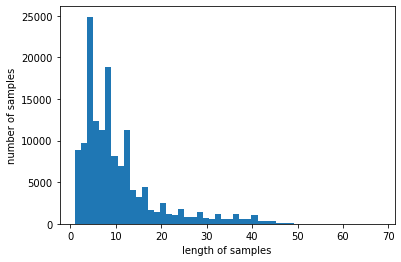

In [28]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show();

In [29]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [30]:
# max_len = 30이 적당할 것 같습니다. 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.58846871921351


In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=777)

In [34]:
# 패키지 준비

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## LSTM 모델 (85.6%)

In [35]:
# 모델 설계

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [36]:
# 모델 검증

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('new_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [37]:
# 모델 훈련

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [38]:
history = model.fit(X_train, y_train, epochs=20, batch_size=60, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
1936/1936 [==============================] - 16s 6ms/step - loss: 0.3881 - acc: 0.8248 - val_loss: 0.3579 - val_acc: 0.8391

Epoch 00001: val_acc improved from -inf to 0.83910, saving model to new_best_model.h5
Epoch 2/20
1936/1936 [==============================] - 11s 6ms/step - loss: 0.3256 - acc: 0.8594 - val_loss: 0.3366 - val_acc: 0.8516

Epoch 00002: val_acc improved from 0.83910 to 0.85164, saving model to new_best_model.h5
Epoch 3/20
1936/1936 [==============================] - 11s 6ms/step - loss: 0.2999 - acc: 0.8739 - val_loss: 0.3440 - val_acc: 0.8523

Epoch 00003: val_acc improved from 0.85164 to 0.85230, saving model to new_best_model.h5
Epoch 4/20
1936/1936 [==============================] - 11s 6ms/step - loss: 0.2821 - acc: 0.8839 - val_loss: 0.3342 - val_acc: 0.8555

Epoch 00004: val_acc improved from 0.85230 to 0.85550, saving model to new_best_model.h5
Epoch 5/20
1936/1936 [==============================] - 11s 6ms/step - loss: 0.2656 - acc: 0.8908 - val

In [39]:
# 테스트 정확도 측정

loaded_model = load_model('new_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 4s 2ms/step - loss: 0.3426 - acc: 0.8548

 테스트 정확도: 0.8548


- 좋은 전처리 만으로도 성능이 많이 향상되었다

### word2vec embedding + LSTM (85.3%)

In [43]:
from gensim.models import Word2Vec

In [40]:
text = tokenizer.sequences_to_texts(X_train)

In [ ]:
text = [t.split(' ') for t in text]

In [46]:
text[:5]

[['것', '영화', '라고', '투자', '돈', '아깝다'],
 ['학창시절', '너무', '너무', '재밌다', '본', '영화', '이다', '내', '인생', '걸작'],
 ['딱', '급', '공포', '미스터리', '해외', '서도', '보다', '비디오', '직행', '인', '듯'],
 ['여름', '시원하다', '이야기', '시원하다', '날다', '팍', '끝'],
 ['그냥', '웃다', '보다', '삼류', '영화']]

In [47]:
model = Word2Vec(text, window=5, min_count = 10, workers=1)

In [50]:
for sim_word in model.wv.most_similar("영화"):  
    print(sim_word)

('애니', 0.6280162334442139)
('다큐', 0.5675877928733826)
('애니메이션', 0.5668386816978455)
('일이', 0.5317996144294739)
('프로그램', 0.5257639288902283)
('독립영화', 0.5176438093185425)
('작품', 0.5149559378623962)
('다큐멘터리', 0.5122169852256775)
('액션영화', 0.49733448028564453)
('공포영화', 0.49510762095451355)


In [52]:
word_vectors = model.wv  
vocabs = list(word_vectors.key_to_index)

In [53]:
word_vectors_list = [word_vectors[v] for v in vocabs]

In [54]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('naver_review_w2v') # 모델 저장
# loaded_model = KeyedVectors.load_word2vec_format('naver_review_w2v') # 모델 로드

## 임베딩 결과 시각화

In [97]:
import warnings
warnings.filterwarnings('ignore')

In [98]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
# font_list[:]

In [99]:
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline

fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [100]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import KeyedVectors

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# plt.rc('font', family='D2Coding')

def show_tsne():
    tsne = TSNE(n_components=2)
    X = tsne.fit_transform(X_show)

    df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y'])
    fig = plt.figure()
    fig.set_size_inches(30, 20)
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(df['x'], df['y'])

    for word, pos in df.iterrows():
        ax.annotate(word, pos, fontsize=10)

    plt.xlabel("t-SNE 특성 0")
    plt.ylabel("t-SNE 특성 1")
    plt.show()


def show_pca():
    # PCA 모델을 생성합니다
    pca = PCA(n_components=2)
    pca.fit(X_show)
    # 처음 두 개의 주성분으로 숫자 데이터를 변환합니다
    x_pca = pca.transform(X_show)

    plt.figure(figsize=(30, 20))
    plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max())
    plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max())
    for i in range(len(X_show)):
        plt.text(x_pca[i, 0], x_pca[i, 1], str(vocab_show[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xlabel("첫 번째 주성분")
    plt.ylabel("두 번째 주성분")
    plt.show()

In [101]:
# from gensim.models import KeyedVectors
# model.wv.save_word2vec_format('naver_review_w2v') # 모델 저장
# loaded_model = KeyedVectors.load_word2vec_format('naver_review_w2v') # 모델 로드

In [92]:
loaded_model = KeyedVectors.load_word2vec_format('naver_review_w2v')

In [106]:
!python -m gensim.scripts.word2vec2tensor --input naver_review_w2v --output naver_review_w2v

2024-06-12 16:30:11,281 - word2vec2tensor - INFO - running /opt/conda/lib/python3.9/site-packages/gensim/scripts/word2vec2tensor.py --input naver_review_w2v --output naver_review_w2v
2024-06-12 16:30:11,281 - keyedvectors - INFO - loading projection weights from naver_review_w2v
2024-06-12 16:30:11,723 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (7782, 100) matrix of type float32 from naver_review_w2v', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-06-12T16:30:11.718071', 'gensim': '4.1.2', 'python': '3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.146+-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}
2024-06-12 16:30:12,212 - word2vec2tensor - INFO - 2D tensor file saved to naver_review_w2v_tensor.tsv
2024-06-12 16:30:12,212 - word2vec2tensor - INFO - Tensor metadata file saved to naver_review_w2v_metadata.tsv
2024-06-12 16:30:12,213 - word2vec2tensor - INFO - finished running word2vec2tensor

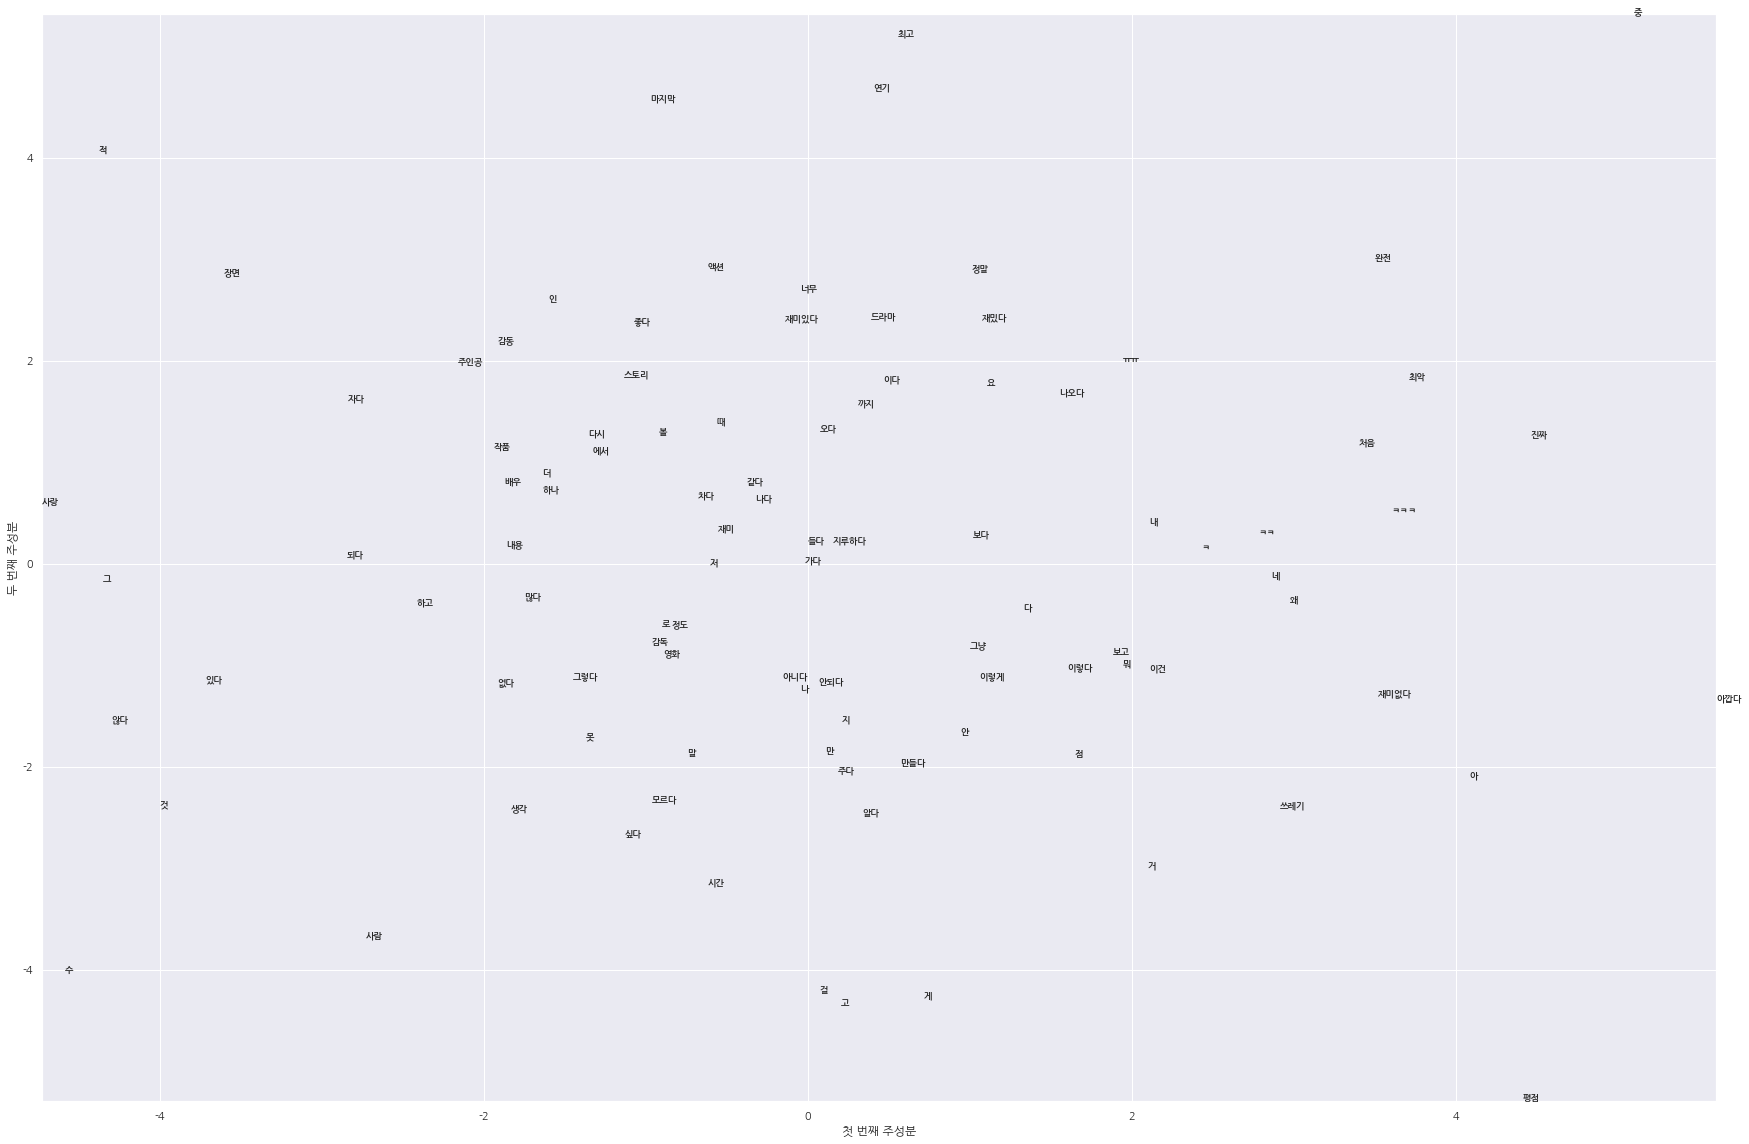

In [103]:
vocab = list(loaded_model.key_to_index)
X = loaded_model[vocab]

# sz개의 단어에 대해서만 시각화
sz = 100
X_show = X[:sz,:]
vocab_show = vocab[:sz]

show_pca()

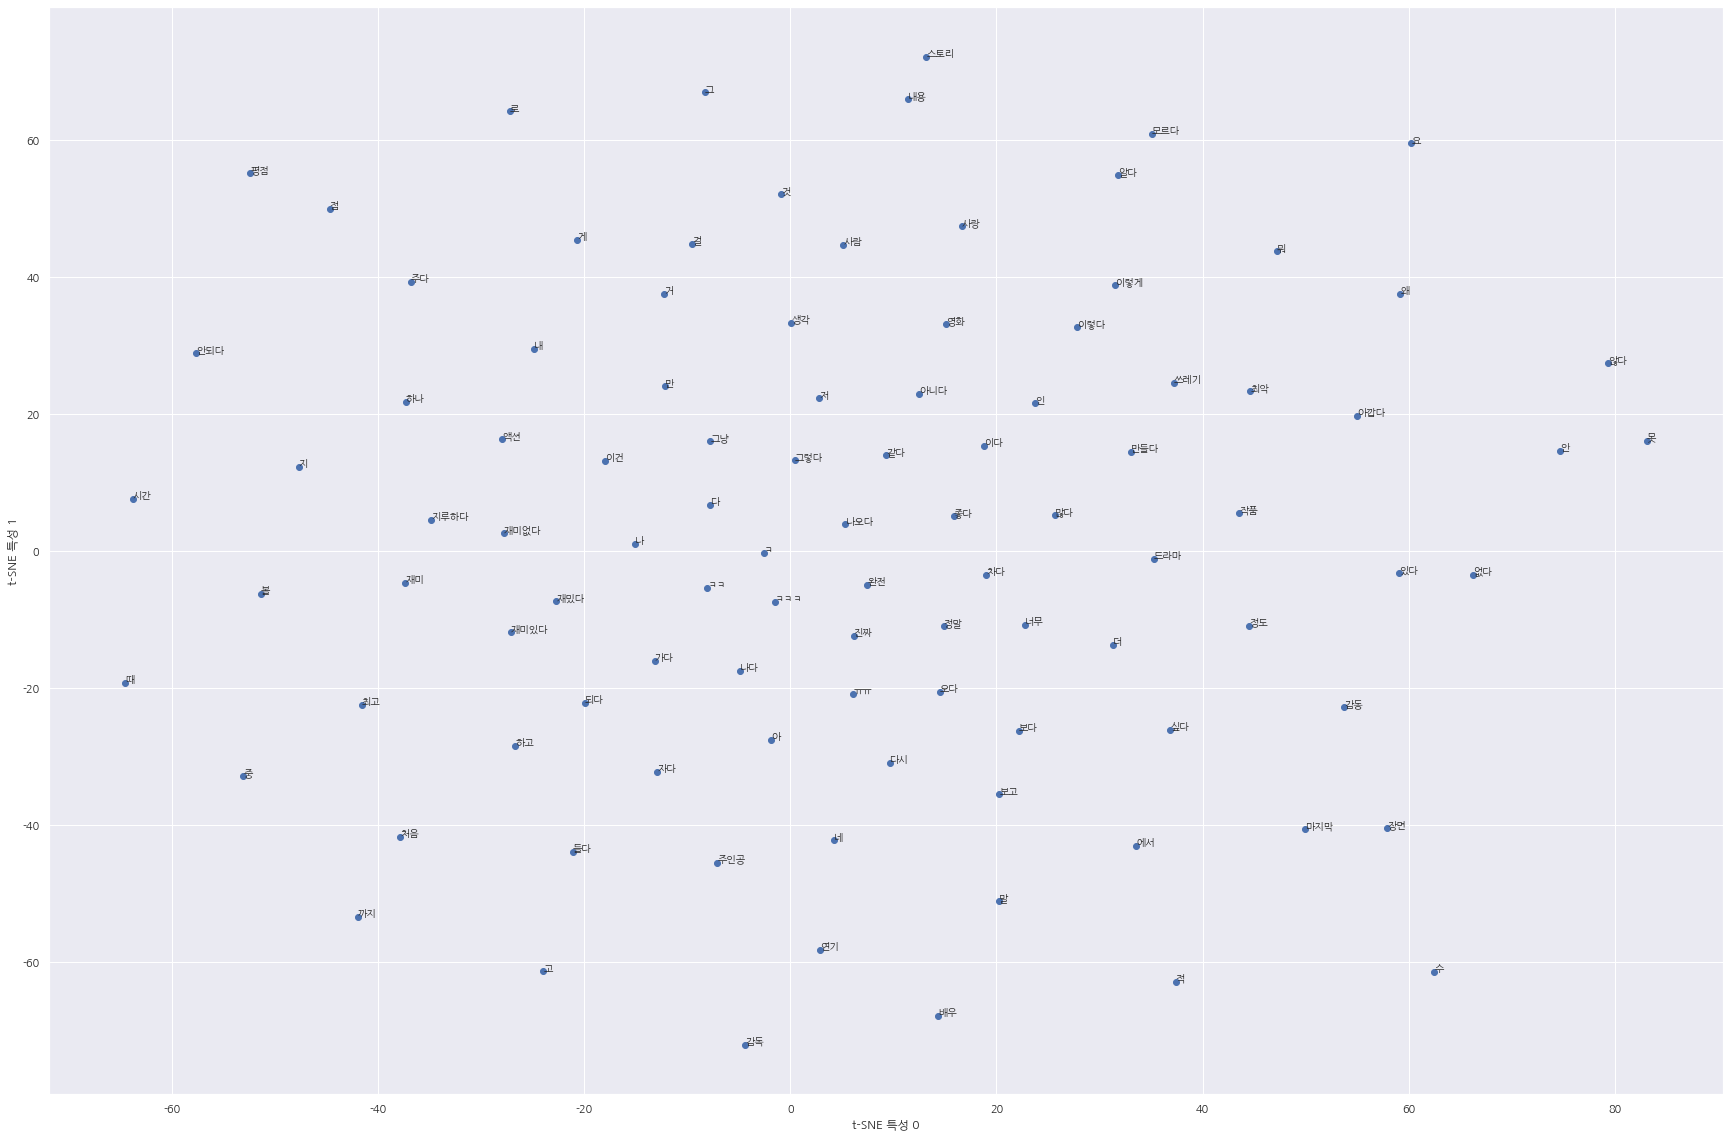

In [104]:
show_tsne()

### Embedding Projector

- 자세한 시각화를 위해 이 페이지를 이용했다 (https://projector.tensorflow.org/)
    
        !python -m gensim.scripts.word2vec2tensor --input naver_review_w2v --output naver_review_w2v

- 위 코드를 통해 저장한 tsv 파일을 이용한다

![img](embedding.png)

## 임베딩

In [59]:
import os

In [60]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'

In [61]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [65]:
vocab_size = len(tokenizer.word_index) + 1
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for word, i in tokenizer.word_index.items():
    if word in word_vectors.wv.key_to_index:
        embedding_matrix[i] = word_vectors.wv[word]

In [66]:
embedding_matrix

array([[ 0.85433054,  0.24713455,  0.25111813, ...,  0.74865966,
         0.89084436,  0.24770857],
       [-1.80073893, -1.1790098 , -2.4066596 , ...,  3.72902226,
         4.62329006,  1.50046134],
       [ 2.47525764, -1.68325222,  0.10577244, ...,  2.61191511,
         3.89895463,  2.51478982],
       ...,
       [ 0.96802867,  0.11019515,  0.71136444, ...,  0.68912931,
         0.23315964,  0.70822724],
       [ 0.08131211,  0.59892372,  0.56248091, ...,  0.91939802,
         0.7756975 ,  0.4408798 ],
       [ 0.44095346, -0.0849321 , -0.05275654, ..., -0.06064855,
         0.27204168,  0.10001441]])

In [67]:
# 모델 설계

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [68]:
# 모델 검증

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('new_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [69]:
# 모델 훈련

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [70]:
history = model.fit(X_train, y_train, epochs=20, batch_size=60, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
1936/1936 [==============================] - 16s 7ms/step - loss: 0.4250 - acc: 0.7981 - val_loss: 0.3702 - val_acc: 0.8327

Epoch 00001: val_acc improved from -inf to 0.83273, saving model to new_best_model.h5
Epoch 2/20
1936/1936 [==============================] - 11s 6ms/step - loss: 0.3339 - acc: 0.8532 - val_loss: 0.3553 - val_acc: 0.8419

Epoch 00002: val_acc improved from 0.83273 to 0.84193, saving model to new_best_model.h5
Epoch 3/20
1936/1936 [==============================] - 11s 6ms/step - loss: 0.2993 - acc: 0.8714 - val_loss: 0.3439 - val_acc: 0.8520

Epoch 00003: val_acc improved from 0.84193 to 0.85199, saving model to new_best_model.h5
Epoch 4/20
1936/1936 [==============================] - 11s 6ms/step - loss: 0.2696 - acc: 0.8872 - val_loss: 0.3472 - val_acc: 0.8540

Epoch 00004: val_acc improved from 0.85199 to 0.85402, saving model to new_best_model.h5
Epoch 5/20
1936/1936 [==============================] - 11s 6ms/step - loss: 0.2396 - acc: 0.9011 - val

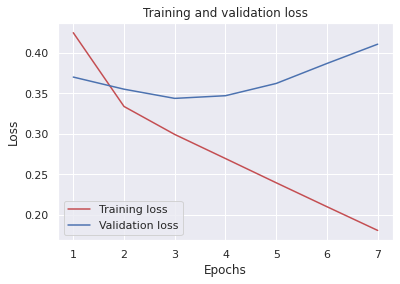

In [81]:
draw_graph(history)

In [74]:
# 테스트 정확도 측정

loaded_model = load_model('new_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 4s 3ms/step - loss: 0.3478 - acc: 0.8526

 테스트 정확도: 0.8526


## 1D CNN 모델 (84.7%)

In [82]:
from tensorflow.keras.initializers import Constant

In [83]:
embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.3 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

vocab_size = len(tokenizer.word_index) + 1
word_vector_dim = 100

In [84]:
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('new_embedding_cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         4375100   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         77056     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [85]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3629/3629 [==============================] - 22s 6ms/step - loss: 0.5222 - acc: 0.7329 - val_loss: 0.3921 - val_acc: 0.8205

Epoch 00001: val_acc improved from -inf to 0.82050, saving model to new_embedding_cnn_best_model.h5
Epoch 2/20
3629/3629 [==============================] - 20s 5ms/step - loss: 0.3901 - acc: 0.8273 - val_loss: 0.3675 - val_acc: 0.8345

Epoch 00002: val_acc improved from 0.82050 to 0.83452, saving model to new_embedding_cnn_best_model.h5
Epoch 3/20
3629/3629 [==============================] - 20s 5ms/step - loss: 0.3573 - acc: 0.8455 - val_loss: 0.3528 - val_acc: 0.8455

Epoch 00003: val_acc improved from 0.83452 to 0.84554, saving model to new_embedding_cnn_best_model.h5
Epoch 4/20
3629/3629 [==============================] - 19s 5ms/step - loss: 0.3336 - acc: 0.8583 - val_loss: 0.3472 - val_acc: 0.8476

Epoch 00004: val_acc improved from 0.84554 to 0.84761, saving model to new_embedding_cnn_best_model.h5
Epoch 5/20
3629/3629 [=========================

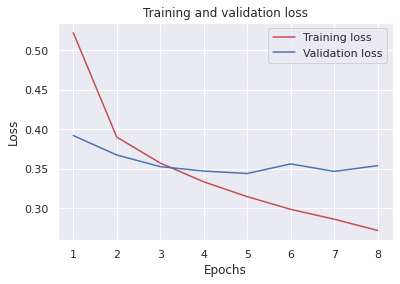

In [86]:
draw_graph(history)

In [87]:
# 테스트 정확도 측정
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 3s 2ms/step - loss: 0.3548 - acc: 0.8490

 테스트 정확도: 0.8490


## 회고

__배운점__
- Embedding이 성능향상을 내는 것을 볼 수 있었다.
    - 안정적인 학습이 가능해지는 것을 확인하였다
    - 하지만 lstm 모델에서는 성능이 향상이 되지 않았다
- 전처리를 다시 한 이후에는 전처리 만으로 성능이 많이 향상되었고 word2vec을 사용하지 않아도 85%이상의 성능이 나오게 되었다


__아쉬운점__
- tokenizer 별로 성능 정리를 해보고 싶었는데 시간상의 이유로 하지 못해서 아쉽다
- overfitting 문제가 많이 발생해서 이를 해결하기 위한 시도를 좀 더 해보고 싶다

__느낀 점__
- 한국어의 자연어 처리가 영어보다 훨씬 어려운 것 같다
- Tokenizer 선정도 상당히 중요한 요소이다

__어려웠던 점__
- word2vec 임베딩을 주입시키는 과정이 어려웠다